In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.neural_network import *
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

from sklearn.gaussian_process.kernels import RBF
import datetime

import pickle
from google.colab import files

from google.colab import drive

drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset docs

https://catalog.data.gov/dataset/crime-data-from-2020-to-present

https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data

In [5]:
DATASET_PATH = '/content/drive/MyDrive/UB school work/Spring 24/DL/assignment0/crime.csv'
assert os.path.exists(DATASET_PATH), 'dataset not found'

In [6]:
df = pd.read_csv(DATASET_PATH)
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,1822 1501 0930 2004,28,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [7]:
# Test modeling a

In [8]:
a = df.describe()
a
# for col in a.columns:
#   print(col)
#   print(a[col])
#   print('=' * 10)

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,8.839870e+05,883987.000000,883987.000000,883987.000000,883987.000000,883987.000000,883987.000000,883977.000000,306604.000000,883976.000000,64497.000000,2176.000000,62.000000,883987.000000,883987.000000
mean,2.173618e+08,1336.560971,10.703108,1116.747620,1.411516,500.758133,29.660630,306.299510,363.322520,500.499365,957.820379,983.770221,990.983871,33.986470,-118.051153
std,1.139578e+07,653.232813,6.100755,610.076564,0.492109,207.629796,21.825831,217.174128,123.705678,207.419239,110.885829,52.538656,27.477259,1.725364,5.981531
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-3.000000,101.000000,101.000000,110.000000,210.000000,310.000000,821.000000,0.000000,-118.667600
25%,2.103145e+08,900.000000,6.000000,615.000000,1.000000,331.000000,0.000000,101.000000,310.000000,331.000000,998.000000,998.000000,998.000000,34.014300,-118.429700
50%,2.203222e+08,1415.000000,11.000000,1141.000000,1.000000,442.000000,31.000000,203.000000,400.000000,442.000000,998.000000,998.000000,998.000000,34.058500,-118.321500
75%,2.302216e+08,1900.000000,16.000000,1615.000000,2.000000,626.000000,45.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.000000,34.163500,-118.273900
max,2.499046e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,976.000000,516.000000,956.000000,999.000000,999.000000,999.000000,34.334300,0.000000


In [9]:
print(df.columns)

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883987 entries, 0 to 883986
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           883987 non-null  int64  
 1   Date Rptd       883987 non-null  object 
 2   DATE OCC        883987 non-null  object 
 3   TIME OCC        883987 non-null  int64  
 4   AREA            883987 non-null  int64  
 5   AREA NAME       883987 non-null  object 
 6   Rpt Dist No     883987 non-null  int64  
 7   Part 1-2        883987 non-null  int64  
 8   Crm Cd          883987 non-null  int64  
 9   Crm Cd Desc     883987 non-null  object 
 10  Mocodes         760974 non-null  object 
 11  Vict Age        883987 non-null  int64  
 12  Vict Sex        766927 non-null  object 
 13  Vict Descent    766919 non-null  object 
 14  Premis Cd       883977 non-null  float64
 15  Premis Desc     883447 non-null  object 
 16  Weapon Used Cd  306604 non-null  float64
 17  Weapon Des

## 2.Provide main statistic about the dataset (e.g. number of entries, features)

In [11]:
description_map = {
    'DR_NO': 'case number',
    'Date Rptd': '',
    'DATE OCC': '',
    'TIME OCC': '',
    'Crm Cd': 'Crime Code',
    'Crm Cd Desc': 'Crime Description',
    'Status': 'Case Status',
    'Mocodes': 'Modus Operandi: Activities associated with the suspect in commission of the crime',
    'Premis Cd': 'The type of structure, vehicle, or location where the crime took place.',
    'Vict Descent': 'Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian \n\
    F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native\n\
    J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian \n\
    V - Vietnamese W - White X - Unknown Z - Asian Indian'
}
race_code_to_name = {
  'A':'Other Asian',
  'B':'Black',
  'C':'Chinese' ,
  'D':'Cambodian',
  'F':'Filipino',
  'G':'Guamanian',
  'H':'Hispanic/Latin/Mexican',
  'I':'American Indian/Alaskan Native',
  'J':'Japanese',
  'K':'Korean',
  'L':'Laotian',
  'O':'Other',
  'P':'Pacific Islander',
  'S':'Samoan',
  'U':'Hawaiian',
  'V':'Vietnamese',
  'W':'White',
  'Z':'Asian Indian',
  'X':'Unknown'
}


In [12]:

missing = df.isna().sum()
stats = {}
all_rows = df.shape[0]

for index, na_count in zip(missing.index, missing.values):
  stats[index] = (na_count, (na_count / all_rows) * 100)

print('DATASETS STATS')
print('number of features = ', df.shape[1])
print('number of entries = ', df.shape[0])
print('missing values count =', df.isna().sum().sum())
print('missing values by feature')
missing = df.isna().sum()
print('-' * 20)

for col in df.columns:
  string = col + '\n'
  if col in stats:
    count, percentage = stats[col]
    string += f'NA count = {count}, ({percentage:.2f}%)\n'
  if col in description_map:
    string += f'[EXPLAIN]: {description_map[col]}\n'
  print(string)
  print('-' * 20)

DATASETS STATS
number of features =  28
number of entries =  883987
missing values count = 4841902
missing values by feature
--------------------
DR_NO
NA count = 0, (0.00%)
[EXPLAIN]: case number

--------------------
Date Rptd
NA count = 0, (0.00%)
[EXPLAIN]: 

--------------------
DATE OCC
NA count = 0, (0.00%)
[EXPLAIN]: 

--------------------
TIME OCC
NA count = 0, (0.00%)
[EXPLAIN]: 

--------------------
AREA
NA count = 0, (0.00%)

--------------------
AREA NAME
NA count = 0, (0.00%)

--------------------
Rpt Dist No
NA count = 0, (0.00%)

--------------------
Part 1-2
NA count = 0, (0.00%)

--------------------
Crm Cd
NA count = 0, (0.00%)
[EXPLAIN]: Crime Code

--------------------
Crm Cd Desc
NA count = 0, (0.00%)
[EXPLAIN]: Crime Description

--------------------
Mocodes
NA count = 123013, (13.92%)
[EXPLAIN]: Modus Operandi: Activities associated with the suspect in commission of the crime

--------------------
Vict Age
NA count = 0, (0.00%)

--------------------
Vict Sex
NA

## 3.Handle missing entries, if any. Possible solutions:

In [13]:
print(df['LOCATION'].unique())

['1900 S  LONGWOOD                     AV'
 '1000 S  FLOWER                       ST'
 '1400 W  37TH                         ST' ... '12100    TERRA BELLA'
 '3600    COLISEUM                     ST'
 '6400 N  FIGUEROAA                    ST']


In [14]:
# Filling NA values
# --------------------
# Vict Sex: X for unknown
df['Vict Sex'].fillna('X', inplace = True)
# Vict Dsectnt : X for unknown
df['Vict Descent'].fillna('X', inplace = True)
# Weapons Used: no weapons used (hypothesis that suspect didn't use weapons),
# fill with 0s
df['Weapon Used Cd'].fillna(0, inplace = True)
# Weapons Desc: no weapons used (NA values = to weapon used), fill with no weapons
df['Weapon Desc'].fillna('None', inplace = True)
#Mocodes: fill with 0s for NA
df['Mocodes'].fillna(0, inplace = True)
#Vict sex: fill with X for NA
df['Vict Sex'].fillna('X', inplace = True)
#Crime code 1,2,3,4: fill with code 0 for NA
df['Crm Cd 1'].fillna(0, inplace = True)
df['Crm Cd 2'].fillna(0, inplace = True)
df['Crm Cd 3'].fillna(0, inplace = True)
df['Crm Cd 4'].fillna(0, inplace = True)
#Fill Cross Street NAs with 'Unknown'
df['Cross Street'].fillna('Unknown', inplace = True)

#Dropping rows
# --------------------
# Premis CD: drop NAs
df.dropna(subset = ['Premis Cd', 'Premis Desc'], inplace = True)

#Some extra stuff
#Replace symbol - in Victim Descent to unknown X
df['Vict Descent'].replace('-', 'X', inplace = True)

print('missing values count =', df.isna().sum().sum())


missing values count = 0


## 4.Handle mismatched string formats
all values are unique

## 5.Handle outliers

Detect outliers in Vict Age
Victim age:
<= 0: likely to happen when there's no victim as a person directly involved




In [15]:
# prompt: detect outliers using IQR method for Vict Age column

Q1 = df['Vict Age'].quantile(0.25)
Q3 = df['Vict Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[((df['Vict Age'] < lower_bound) | (df['Vict Age'] > upper_bound))]

print(f"Number of outliers: {len(outliers)}")


Number of outliers: 1


## 6.Provide at least 5 visualization graphs related to your dataset.

<Axes: xlabel='None'>

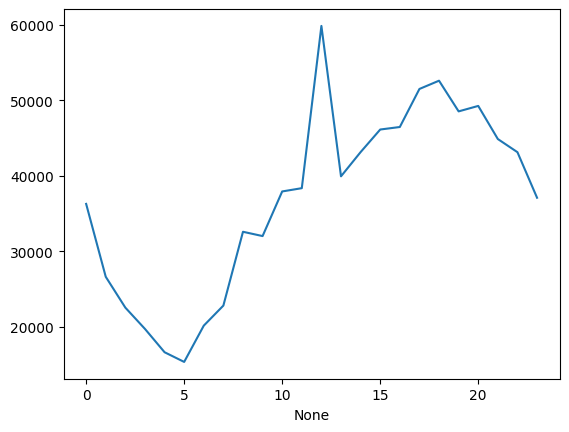

In [16]:
def to_hour(raw_time):
  raw_time = str(raw_time).zfill(4)
  hours = int(raw_time[:2])
  minutes = int(raw_time[2:])
  return hours

# print(to_minute_of_day(300))

df["HOUR OCC"] = df['TIME OCC'].apply(to_hour)

hour_occ = df['HOUR OCC'].value_counts()

sns.lineplot(x = hour_occ.index, y = hour_occ.values)

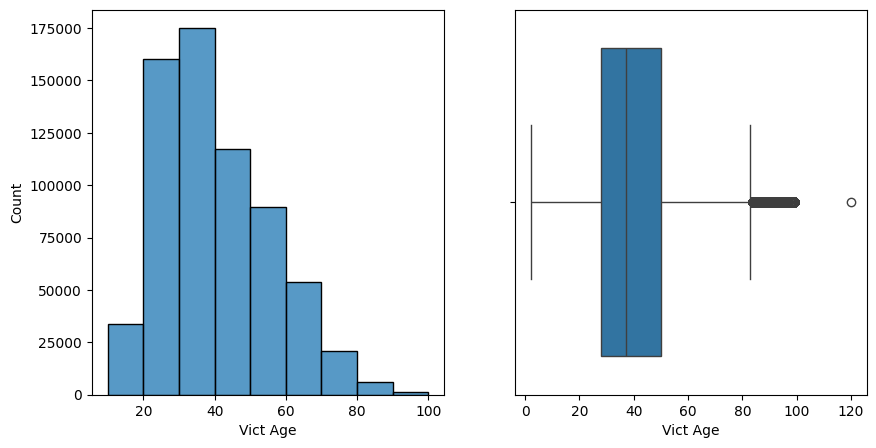

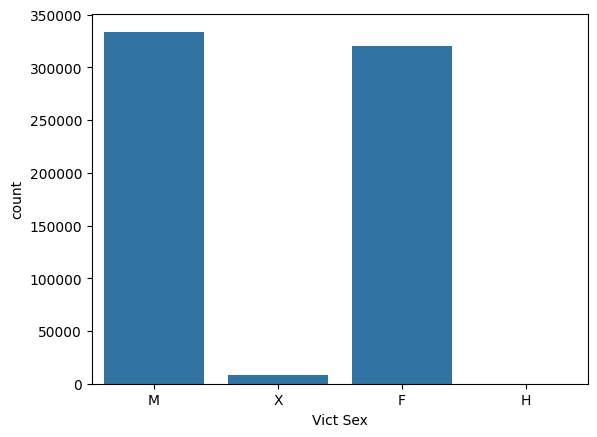

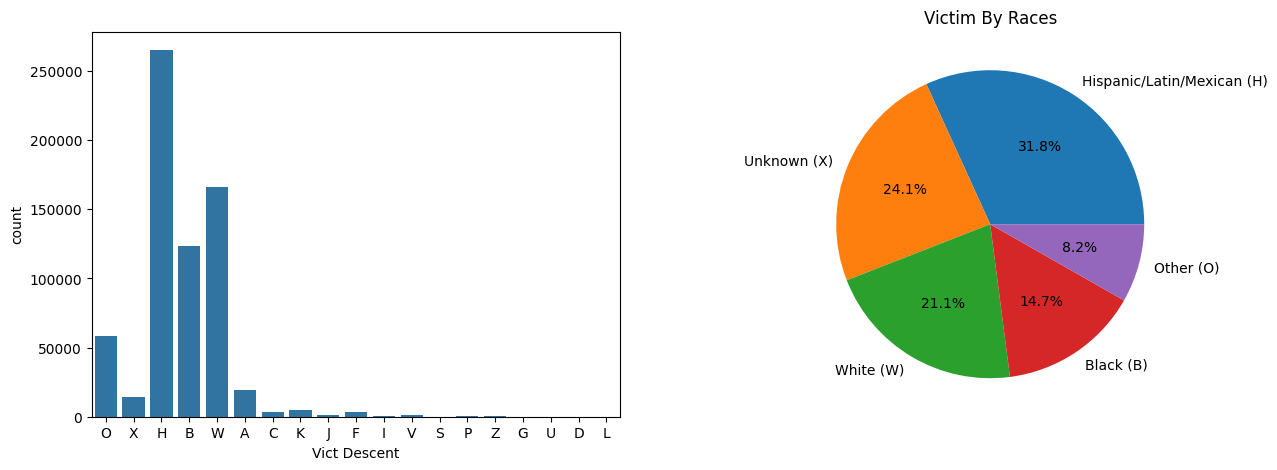

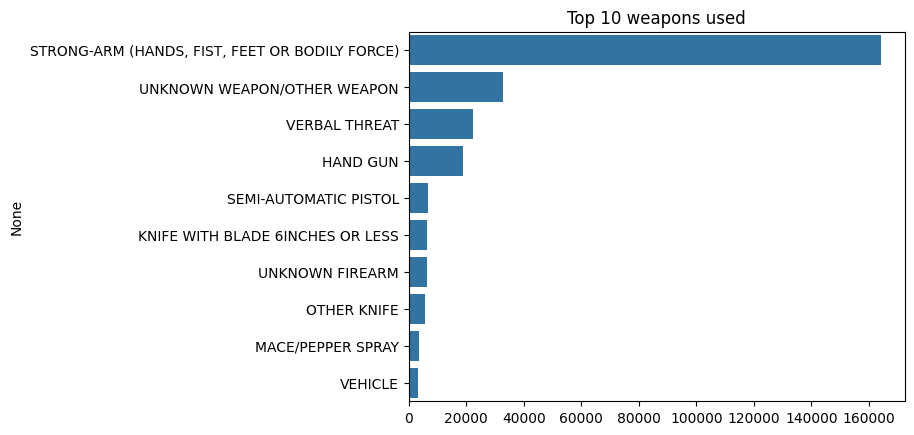

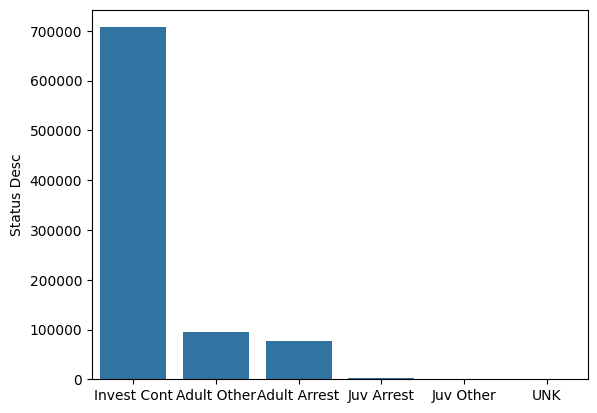

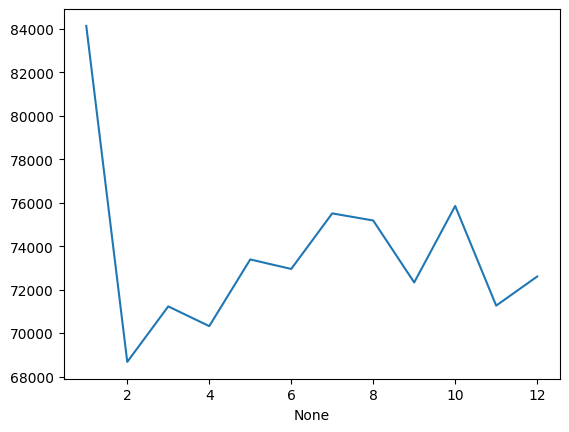

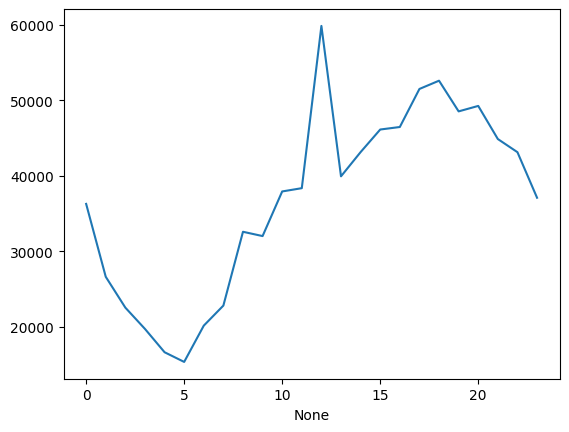

In [17]:
# Plot histogram for Vict age:
# what age groups more likely to be a victim?
# sns.histplot(df, x= 'Vict Age', bins = [18, 25, 30, 40, 50, 60])
# NOTE: we ignore 0 because we HYPOTHESIS that if victim age < 0 ==> no victim injured when crime happened
person_victim =df.loc[(df['Vict Age'] > 0)]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

sns.histplot(person_victim, x= 'Vict Age', bins = [10,20,30,40,50,60,70,80,90,100], ax = ax1)
sns.boxplot(person_victim, x = 'Vict Age', ax = ax2)
plt.show()

# Count plot for sex
# what gender more likely to be a victim?
sns.countplot(person_victim, x= 'Vict Sex')
plt.show()


#Plotting pie chart for victims by race
victim_by_race = df['Vict Descent'].value_counts()
labels = []
victim_by_race

values =[]
other = 0
for i, v in enumerate(victim_by_race.values):
  if i < 5:
    values.append(v)
  else:
    other += v

labels = [f'{race_code_to_name[k]} ({k})' for k in victim_by_race.index if k in race_code_to_name]
labels = labels[:5]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

# count plot for race
# what race is more likely to be a victim?
sns.countplot(person_victim, x= 'Vict Descent', ax = ax1)
ax2.pie(values, labels=labels, autopct='%1.1f%%')
ax2.set_title('Victim By Races')
plt.show()

# count plot for weapons desc
# What weapons mostly used to commit crimes?
test = df.loc[df['Weapon Desc'] != 'None']['Weapon Desc'].value_counts()[:10]
values = test.values
labels = test.index
sns.barplot(x = values, y = labels)
plt.title("Top 10 weapons used")
plt.show()

# plot areas in LA to visualize frequency of crimes

# count plot for status
sns.barplot(df['Status Desc'].value_counts())
plt.show()

# frequency based on time of day,
# what time crimes usually happen?

# frequency based on month
def to_day_of_year(raw_date):
  dateobj = datetime.datetime.strptime(raw_date, '%m/%d/%Y %I:%M:%S %p')
  return dateobj.timetuple().tm_yday

def to_month(raw_date):
  dateobj = datetime.datetime.strptime(raw_date, '%m/%d/%Y %I:%M:%S %p')
  return dateobj.month

df['DAY OF YEAR OCC'] = df['DATE OCC'].apply(to_day_of_year)
df['MONTH OCC'] = df['DATE OCC'].apply(to_month)

occ = df['MONTH OCC'].value_counts()
sns.lineplot(x = occ.index, y = occ.values)
# what day of year crimes usually happen?
# we want to highlight if crimes usually happen in holiday
plt.show()

# what hour of day occur more?
def to_hour(raw_time):
  raw_time = str(raw_time).zfill(4)
  hours = int(raw_time[:2])
  minutes = int(raw_time[2:])
  return hours

# print(to_minute_of_day(300))

df["HOUR OCC"] = df['TIME OCC'].apply(to_hour)

hour_occ = df['HOUR OCC'].value_counts()

sns.lineplot(x = hour_occ.index, y = hour_occ.values)
plt.show()

#Extra stuff
#crime map

In [18]:
print(hour_occ.index)
print(hour_occ.values)

Int64Index([12, 18, 17, 20, 19, 16, 15, 21, 14, 22, 13, 11, 10, 23,  0,  8,  9,
             1,  7,  2,  6,  3,  4,  5],
           dtype='int64')
[59818 52574 51480 49236 48514 46448 46115 44857 43130 43116 39925 38357
 37924 37091 36278 32590 32022 26637 22829 22556 20174 19742 16658 15376]


## 7.Identify uncorrelated or unrelated features.

<ipython-input-19-49b925f52937>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


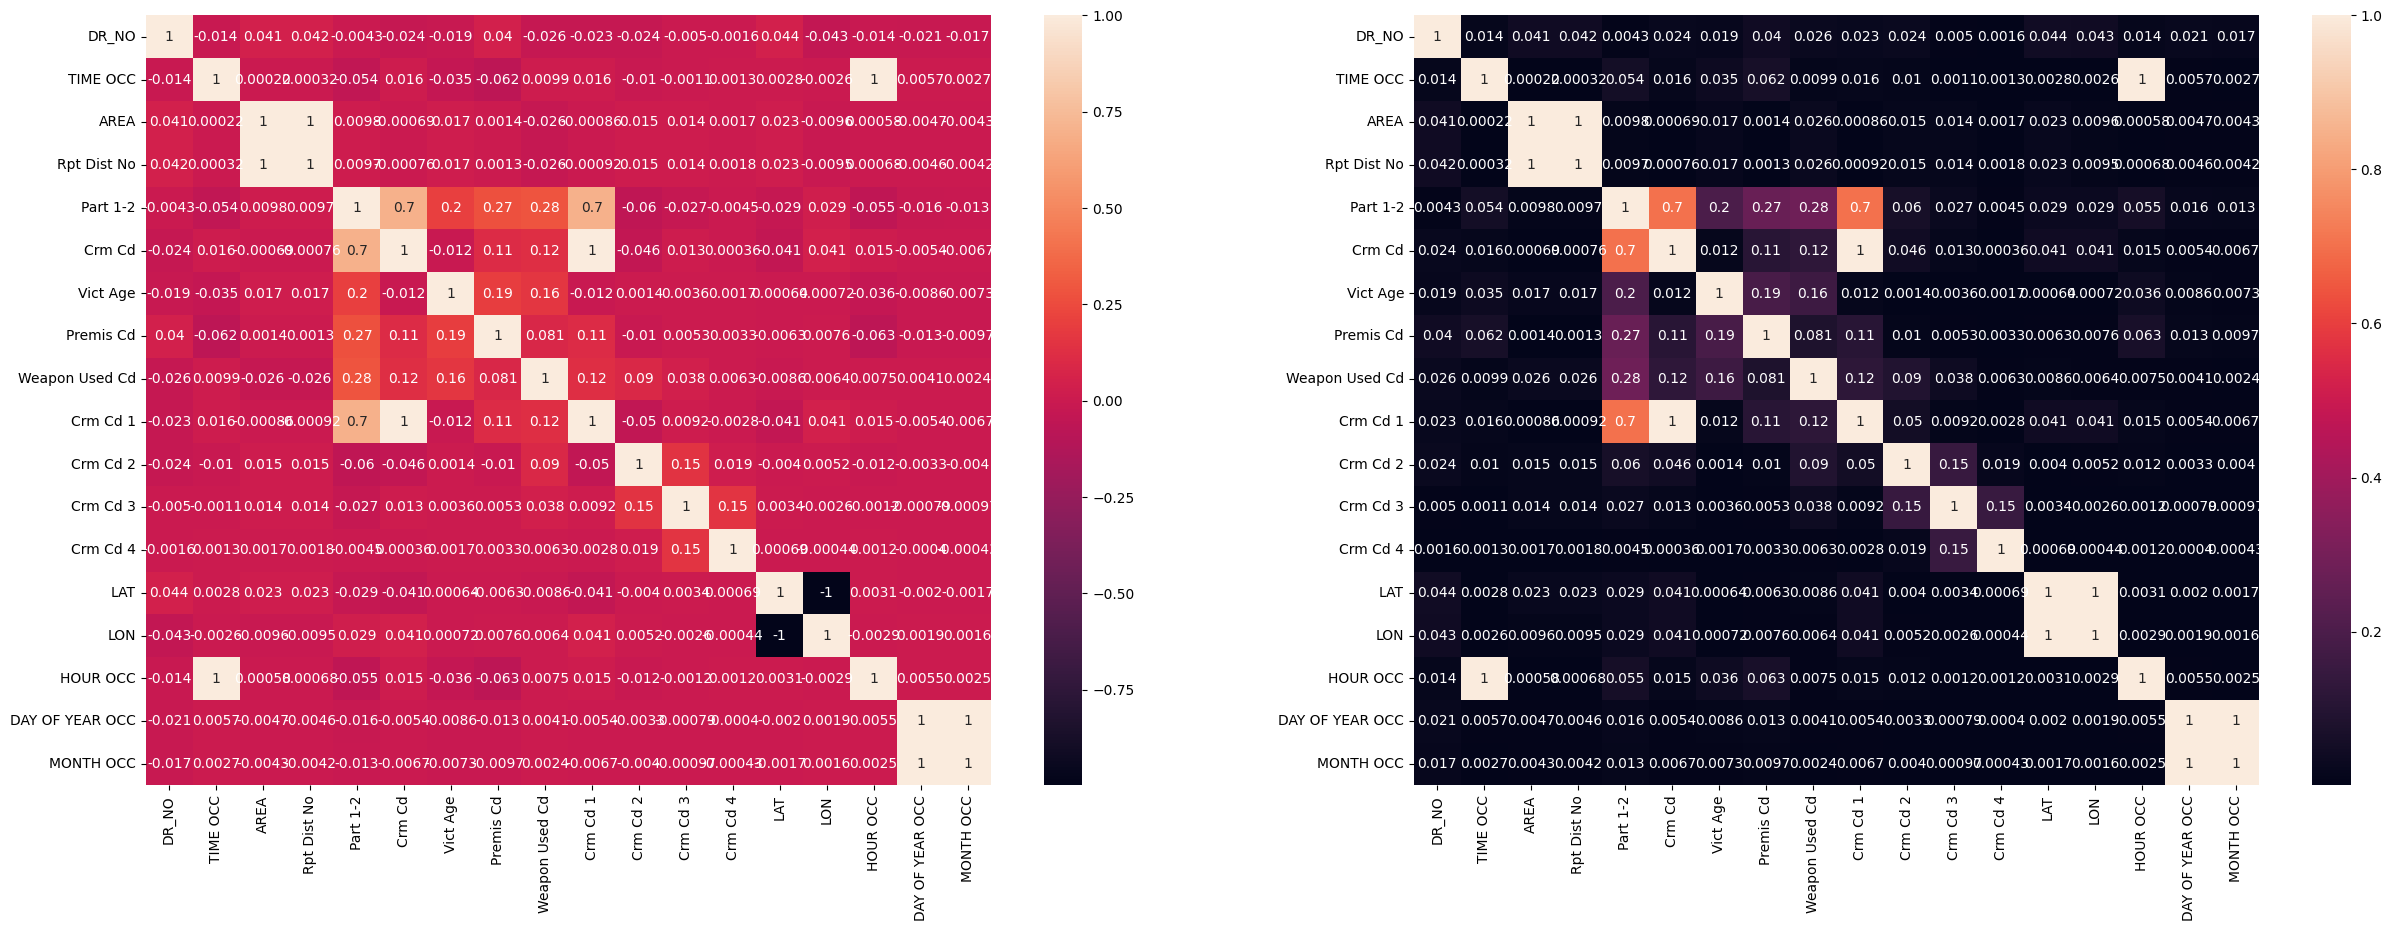

In [19]:
# Get the correlation matrix
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (30,10))
corr = df.corr()
abs_corr = np.abs(corr)

# Create a heatmap
sns.heatmap(corr, annot=True, ax = ax1)
sns.heatmap(abs_corr, annot=True, ax = ax2)
plt.show()


In [20]:
# Dropping uncorrelated features to improve model performance
# experiment 1: don't drop anything

In [21]:
df.head(10)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,HOUR OCC,DAY OF YEAR OCC,MONTH OCC
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,0,0,M,O,101.0,STREET,0.0,None,AA,Adult Arrest,510.0,998.0,0.0,0.0,1900 S LONGWOOD AV,Unknown,34.0375,-118.3506,21,61,3
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),0.0,None,IC,Invest Cont,330.0,998.0,0.0,0.0,1000 S FLOWER ST,Unknown,34.0444,-118.2628,18,39,2
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0.0,None,IC,Invest Cont,480.0,0.0,0.0,0.0,1400 W 37TH ST,Unknown,34.0210,-118.3002,17,309,11
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,0.0,None,IC,Invest Cont,343.0,0.0,0.0,0.0,14000 RIVERSIDE DR,Unknown,34.1576,-118.4387,20,70,3
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,1822 1501 0930 2004,28,M,H,102.0,SIDEWALK,0.0,None,IC,Invest Cont,354.0,0.0,0.0,0.0,1900 TRANSIENT,Unknown,34.0944,-118.3277,12,230,8
5,231808869,04/04/2023 12:00:00 AM,12/01/2020 12:00:00 AM,2300,18,Southeast,1826,2,354,THEFT OF IDENTITY,1822 0100 0930 0929,41,M,H,501.0,SINGLE FAMILY DWELLING,0.0,None,IC,Invest Cont,354.0,0.0,0.0,0.0,9900 COMPTON AV,Unknown,33.9467,-118.2463,23,336,12
6,230110144,04/04/2023 12:00:00 AM,07/03/2020 12:00:00 AM,900,1,Central,182,2,354,THEFT OF IDENTITY,0930 0929,25,M,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0.0,None,IC,Invest Cont,354.0,0.0,0.0,0.0,1100 S GRAND AV,Unknown,34.0415,-118.2620,9,185,7
7,220314085,07/22/2022 12:00:00 AM,05/12/2020 12:00:00 AM,1110,3,Southwest,303,2,354,THEFT OF IDENTITY,0100,27,F,B,248.0,CELL PHONE STORE,0.0,None,IC,Invest Cont,354.0,0.0,0.0,0.0,2500 S SYCAMORE AV,Unknown,34.0335,-118.3537,11,133,5
8,231309864,04/28/2023 12:00:00 AM,12/09/2020 12:00:00 AM,1400,13,Newton,1375,2,354,THEFT OF IDENTITY,0100,24,F,B,750.0,CYBERSPACE,0.0,None,IC,Invest Cont,354.0,0.0,0.0,0.0,1300 E 57TH ST,Unknown,33.9911,-118.2521,14,344,12
9,211904005,12/31/2020 12:00:00 AM,12/31/2020 12:00:00 AM,1220,19,Mission,1974,2,624,BATTERY - SIMPLE ASSAULT,0416,26,M,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,624.0,0.0,0.0,0.0,9000 CEDROS AV,Unknown,34.2336,-118.4535,12,366,12


## 8.Convert features with string datatype to categorical.

In [22]:
# print(df['Weapon Desc'].unique())
print(df['Cross Street'].unique())
print(len(df['LOCATION'].unique()))

['Unknown' 'VANOWEN                      AV' 'INGLEWOOD' ... 'E  101ST'
 'WOODLAWN                     ST' 'GRAYSTONE                    ST']
64792


In [23]:
num_cols = set(df._get_numeric_data().columns)
all_cols = set(df.columns)
cat_cols = all_cols - num_cols

In [24]:
print(df.columns)

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'HOUR OCC', 'DAY OF YEAR OCC', 'MONTH OCC'],
      dtype='object')


### Creating train_df

In [25]:
train_df = df[['MONTH OCC','DAY OF YEAR OCC','TIME OCC', 'AREA', \
               'Rpt Dist No', 'Part 1-2', 'Crm Cd',\
               'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd',\
               'Weapon Used Cd', 'Status',\
               'LOCATION', 'Cross Street', 'LAT', 'LON'
               ]].copy()
#drop rows that have X or H Vict Sex
train_df = train_df.loc[(train_df["Vict Sex"] == 'M') | (train_df['Vict Sex'] == 'F')]
print(train_df.shape)
train_df.head()

(686852, 17)


,MONTH OCC,DAY OF YEAR OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,LOCATION,Cross Street,LAT,LON
0,3,61,2130,7,784,1,510,0,M,O,101.0,0.0,AA,1900 S LONGWOOD AV,Unknown,34.0375,-118.3506
1,2,39,1800,1,182,1,330,47,M,O,128.0,0.0,IC,1000 S FLOWER ST,Unknown,34.0444,-118.2628
3,3,70,2037,9,964,1,343,19,M,O,405.0,0.0,IC,14000 RIVERSIDE DR,Unknown,34.1576,-118.4387
4,8,230,1200,6,666,2,354,28,M,H,102.0,0.0,IC,1900 TRANSIENT,Unknown,34.0944,-118.3277
5,12,336,2300,18,1826,2,354,41,M,H,501.0,0.0,IC,9900 COMPTON AV,Unknown,33.9467,-118.2463


In [26]:
# to convert categorical to numerical
to_convert_cols = [
   'AREA', 'Rpt Dist No', 'Crm Cd', 'Vict Descent','Vict Sex', 'Weapon Used Cd', 'Status', 'LOCATION', 'Cross Street'
]

for col in to_convert_cols:
  print(f'converting {col}')
  le = LabelEncoder()
  train_df[col] = le.fit_transform(train_df[col])

train_df.head()

# AREA NAME
# LOCATION
# Pemis Cd (convert to some continous range starting from 0
#, we don't know if the codes are continous)
# Weapon Used Cd (like above)
# Status
# Crime Cd 1, 2,3,4 (maybe ignore this)
# Cross Street



converting AREA
converting Rpt Dist No
converting Crm Cd
converting Vict Descent
converting Vict Sex
converting Weapon Used Cd
converting Status
converting LOCATION
converting Cross Street


,MONTH OCC,DAY OF YEAR OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,LOCATION,Cross Street,LAT,LON
0,3,61,2130,6,373,1,55,0,1,11,101.0,0,0,20026,7725,34.0375,-118.3506
1,2,39,1800,0,48,1,15,47,1,11,128.0,0,3,1700,7725,34.0444,-118.2628
3,3,70,2037,8,486,1,18,19,1,11,405.0,0,3,12520,7725,34.1576,-118.4387
4,8,230,1200,5,304,2,26,28,1,6,102.0,0,3,19875,7725,34.0944,-118.3277
5,12,336,2300,17,999,2,26,41,1,6,501.0,0,3,53248,7725,33.9467,-118.2463


## 9.Normalize non-categorical features (scale numerical variables to have zero mean and unit variance)

In [27]:
# apply min max scale to each columns in pd
train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())
train_df.describe()


,MONTH OCC,DAY OF YEAR OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,LOCATION,Cross Street,LAT,LON
count,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000,686852.000000
mean,0.495294,0.491268,0.560580,0.488564,0.484688,0.481571,0.333891,0.400646,0.528511,0.455233,0.267863,0.285816,0.494054,0.514492,0.826703,0.989843,0.005298
std,0.314867,0.290172,0.276898,0.306251,0.295603,0.499661,0.258463,0.170503,0.499187,0.310637,0.248878,0.374416,0.208154,0.289312,0.185102,0.051527,0.051687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.181818,0.238356,0.381255,0.250000,0.237615,0.000000,0.111111,0.294118,0.000000,0.333333,0.003448,0.000000,0.600000,0.256671,0.886810,0.990750,0.001963
50%,0.454545,0.493151,0.593299,0.500000,0.495382,0.000000,0.281481,0.382353,1.000000,0.333333,0.347126,0.000000,0.600000,0.540734,0.886810,0.992023,0.002874
75%,0.727273,0.742466,0.782019,0.750000,0.724601,1.000000,0.466667,0.509804,1.000000,0.888889,0.460920,0.784810,0.600000,0.752032,0.886810,0.995168,0.003317
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 10.Choose your target Y and features X

In [35]:
# train_df['AREA'] = df['AREA']
target = 'Vict Sex'
features = train_df.drop(target, axis = 1)
print('Features shape = ', features.shape)
labels = train_df[target]
print('Labels shape = ',labels.shape)

Features shape =  (686852, 16)
Labels shape =  (686852,)


In [36]:
features.head()

,MONTH OCC,DAY OF YEAR OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Descent,Premis Cd,Weapon Used Cd,Status,LOCATION,Cross Street,LAT,LON
0,0.181818,0.164384,0.902884,7,0.313182,0.0,0.407407,0.029412,0.611111,0.000000,0.0,0.0,0.328861,0.88681,0.991356,0.002671
1,0.090909,0.104110,0.762935,1,0.040302,0.0,0.111111,0.490196,0.611111,0.031034,0.0,0.6,0.027917,0.88681,0.991557,0.003411
3,0.181818,0.189041,0.863444,9,0.408060,0.0,0.133333,0.215686,0.611111,0.349425,0.0,0.6,0.205600,0.88681,0.994854,0.001929
4,0.636364,0.627397,0.508482,6,0.255248,1.0,0.192593,0.303922,0.333333,0.001149,0.0,0.6,0.326381,0.88681,0.993013,0.002864
5,1.000000,0.917808,0.974979,18,0.838791,1.0,0.192593,0.431373,0.333333,0.459770,0.0,0.6,0.874423,0.88681,0.988711,0.003550


In [37]:
labels.head()
num_class = len(labels.unique())
print('num classes = ', num_class)

num classes =  2


## 11.Split the dataset into training, testing and validation sets.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(features[:200000], labels[:200000])
print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)

x train shape =  (150000, 16)
y train shape =  (150000,)
x test shape =  (50000, 16)
y test shape =  (50000,)


# STEP 2: ML models

In [43]:
classifers = [
    # ('mlp', MLPClassifier()),
    # ('knn', KNeighborsClassifier(3)),
    # ('svc', SVC(kernel="linear", C=0.025, random_state=42)),
    # ('gaussian', GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42)),
    ('tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('forest', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42, verbose = 1)),
    ('mlp',MLPClassifier(alpha=1, max_iter=1000, random_state=42, verbose = True)),
    # ('ada',AdaBoostClassifier(algorithm="SAMME", random_state=42))
]
# mlp, score = 0.6310005648960766
# knn, score = 0.5802530967369972

In [44]:
for name, cls in classifers:
  cls.fit(x_train, y_train)
  score = cls.score(x_test, y_test)
  print(f'{name}, score = {score}')

  # Save the trained model to a file
  name = f'{name}_{score}.pkl'
  with open(name, 'wb') as f:
    pickle.dump(cls, f)

  # Download the model file to the local machine
  files.download(name)



tree, score = 0.61456


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

forest, score = 0.61178


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Iteration 1, loss = 0.70483351
Iteration 2, loss = 0.67690078
Iteration 3, loss = 0.67369663
Iteration 4, loss = 0.67322087
Iteration 5, loss = 0.67291703
Iteration 6, loss = 0.67229779
Iteration 7, loss = 0.67230726
Iteration 8, loss = 0.67228949
Iteration 9, loss = 0.67195856
Iteration 10, loss = 0.67194801
Iteration 11, loss = 0.67189616
Iteration 12, loss = 0.67197046
Iteration 13, loss = 0.67159857
Iteration 14, loss = 0.67171346
Iteration 15, loss = 0.67163240
Iteration 16, loss = 0.67150098
Iteration 17, loss = 0.67164113
Iteration 18, loss = 0.67185121
Iteration 19, loss = 0.67152514
Iteration 20, loss = 0.67152826
Iteration 21, loss = 0.67137366
Iteration 22, loss = 0.67144580
Iteration 23, loss = 0.67135693
Iteration 24, loss = 0.67127842
Iteration 25, loss = 0.67122038
Iteration 26, loss = 0.67132145
Iteration 27, loss = 0.67123163
Iteration 28, loss = 0.67132522
Iteration 29, loss = 0.67149031
Iteration 30, loss = 0.67138492
Iteration 31, loss = 0.67117986
Iteration 32, los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import pickle
# from google.colab import files

# # Save the trained model to a file
# with open('mlp.pkl', 'wb') as f:
#   pickle.dump(model, f)

# # Download the model file to the local machine
# files.download('mlp.pkl')


# STEP 3: Intro to PyTorch and Building NN

In [ ]:
print(labels.unique())
# print(features.isna().sum())

[ 0 47 19 28 41 25 27 24 26  8  7 13 56 22 23 31 30 57 10 12 46 51 37 20
 29 33 34 15 65 59  9 35 50 64 79 40 44 32 16 21 42  6 72 60 36 18 17  5
 39 62 58 63 14 71 69 49 38 61 43 45 78 67 53 54 11 48 73 52 68 81 80  3
 55 89 70 -2 77 83 91 82 75 76 74 -1  4  2 66 84 87 86 85 90 99 96 88 92
 94 93 95 97 98 -3]


In [ ]:
def accuracy(y_pred, y_train):
  return accuracy_score(y_pred, y_train)

print(accuracy(torch.zeros(10), torch.ones(10)))

0.0


In [46]:
# train_df['Vict Age'] = df['Vict Age']
target = 'Vict Sex'
features = train_df.drop(target, axis = 1)
print('Features shape = ', features.shape)
labels = train_df[target]
classes = len(labels.unique())
print('Labels shape = ',labels.shape)
print('num classes ', classes)

Features shape =  (686852, 16)
Labels shape =  (686852,)
num classes  2


In [47]:
features.head()

,MONTH OCC,DAY OF YEAR OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Descent,Premis Cd,Weapon Used Cd,Status,LOCATION,Cross Street,LAT,LON
0,0.181818,0.164384,0.902884,7,0.313182,0.0,0.407407,0.029412,0.611111,0.000000,0.0,0.0,0.328861,0.88681,0.991356,0.002671
1,0.090909,0.104110,0.762935,1,0.040302,0.0,0.111111,0.490196,0.611111,0.031034,0.0,0.6,0.027917,0.88681,0.991557,0.003411
3,0.181818,0.189041,0.863444,9,0.408060,0.0,0.133333,0.215686,0.611111,0.349425,0.0,0.6,0.205600,0.88681,0.994854,0.001929
4,0.636364,0.627397,0.508482,6,0.255248,1.0,0.192593,0.303922,0.333333,0.001149,0.0,0.6,0.326381,0.88681,0.993013,0.002864
5,1.000000,0.917808,0.974979,18,0.838791,1.0,0.192593,0.431373,0.333333,0.459770,0.0,0.6,0.874423,0.88681,0.988711,0.003550


In [48]:
labels.head()

0    1.0
1    1.0
3    1.0
4    1.0
5    1.0
Name: Vict Sex, dtype: float64

In [49]:
x_train, x_test, y_train, y_test = train_test_split(features[:200000], labels[:200000], shuffle = True)
print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)

x train shape =  (150000, 16)
y train shape =  (150000,)
x test shape =  (50000, 16)
y test shape =  (50000,)


In [50]:
class CrimeDataset(Dataset):
  def __init__(self, x_train, y_train):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('x_train shape = ', x_train.shape)
    print('y_train shape = ', y_train.shape)
    self.x = torch.tensor(x_train.to_numpy(), device = device).type(torch.float)
    self.y = torch.tensor(y_train.to_numpy(), device = device).type(torch.long)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def get_dataloader(self, batch_size = 1024, is_test = False):
    if is_test:
      batch_size = len(self.x)

    dataloader =  DataLoader(self, batch_size = batch_size, shuffle = True)
    return dataloader


train_data = CrimeDataset(x_train, y_train)
test_data = CrimeDataset(x_test, y_test)
train_dataloader = train_data.get_dataloader()
print('train size = ', len(train_dataloader))
test_dataloader = test_data.get_dataloader(is_test = True)
print('test size = ', len(test_dataloader))

x_train shape =  (150000, 16)
y_train shape =  (150000,)
x_train shape =  (50000, 16)
y_train shape =  (50000,)
train size =  147
test size =  1


In [51]:
print(len(train_dataloader))
x,y = next(iter(train_dataloader))
print(x.shape)
print(x.device)
print(x.grad_fn)
print(y.shape)
print(y.grad_fn)
print(y.device)

147
torch.Size([1024, 16])
cpu
None
torch.Size([1024])
None
cpu


In [52]:

import torch
import torch.nn as nn
from torchsummary import summary


In [63]:
model = nn.Sequential(
    nn.LazyLinear(8),
    nn.ReLU(),
    nn.LazyLinear(16),
    nn.ReLU(),
    nn.LazyLinear(classes),
    nn.Sigmoid()
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size = (features.shape))

# optim = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=1.9)
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

epochs = 20
history = []

def accuracy(model, test_dataloader):
  x,y = next(iter(test_dataloader))
  y = y.cpu().numpy()
  y_pred = model(x)
  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)
  return accuracy_score(y, y_pred)

for e in range(epochs):
  print("EPOCH = ", e)
  running_loss = 0.0
  for x,y in tqdm(train_dataloader):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss += loss.item()

  #measure accuracy
  score = accuracy(model, test_dataloader)
  history.append({'loss': running_loss, 'accuracy':score})
  print(f'e={e}, loss = {running_loss}, accuracy = {score}')
  # for p in model.parameters():
  #   print(p)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 686852, 8]             136
              ReLU-2            [-1, 686852, 8]               0
            Linear-3           [-1, 686852, 16]             144
              ReLU-4           [-1, 686852, 16]               0
            Linear-5            [-1, 686852, 2]              34
           Sigmoid-6            [-1, 686852, 2]               0
Total params: 314
Trainable params: 314
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 41.92
Forward/backward pass size (MB): 272.49
Params size (MB): 0.00
Estimated Total Size (MB): 314.42
----------------------------------------------------------------
EPOCH =  0


100%|██████████| 147/147 [00:02<00:00, 52.51it/s]


e=0, loss = 98.75876784324646, accuracy = 0.60378
EPOCH =  1


100%|██████████| 147/147 [00:01<00:00, 76.21it/s] 


e=1, loss = 97.80743145942688, accuracy = 0.60238
EPOCH =  2


100%|██████████| 147/147 [00:01<00:00, 133.95it/s]


e=2, loss = 97.66320317983627, accuracy = 0.60816
EPOCH =  3


100%|██████████| 147/147 [00:00<00:00, 165.28it/s]


e=3, loss = 97.24699223041534, accuracy = 0.6116
EPOCH =  4


100%|██████████| 147/147 [00:01<00:00, 131.47it/s]


e=4, loss = 96.38675022125244, accuracy = 0.61576
EPOCH =  5


100%|██████████| 147/147 [00:01<00:00, 134.42it/s]


e=5, loss = 96.17660009860992, accuracy = 0.6141
EPOCH =  6


100%|██████████| 147/147 [00:01<00:00, 119.02it/s]


e=6, loss = 96.15132945775986, accuracy = 0.61698
EPOCH =  7


100%|██████████| 147/147 [00:01<00:00, 133.01it/s]


e=7, loss = 96.05754280090332, accuracy = 0.61576
EPOCH =  8


100%|██████████| 147/147 [00:01<00:00, 136.60it/s]


e=8, loss = 95.99612087011337, accuracy = 0.61572
EPOCH =  9


100%|██████████| 147/147 [00:00<00:00, 161.73it/s]


e=9, loss = 95.95836585760117, accuracy = 0.61518
EPOCH =  10


100%|██████████| 147/147 [00:01<00:00, 137.31it/s]


e=10, loss = 95.94470500946045, accuracy = 0.61672
EPOCH =  11


100%|██████████| 147/147 [00:01<00:00, 134.83it/s]


e=11, loss = 95.89605438709259, accuracy = 0.61392
EPOCH =  12


100%|██████████| 147/147 [00:00<00:00, 167.79it/s]


e=12, loss = 95.92495512962341, accuracy = 0.6143
EPOCH =  13


100%|██████████| 147/147 [00:01<00:00, 93.32it/s]


e=13, loss = 95.86573702096939, accuracy = 0.61514
EPOCH =  14


100%|██████████| 147/147 [00:01<00:00, 136.90it/s]


e=14, loss = 95.8926687836647, accuracy = 0.61552
EPOCH =  15


100%|██████████| 147/147 [00:00<00:00, 168.61it/s]


e=15, loss = 95.89204049110413, accuracy = 0.61732
EPOCH =  16


100%|██████████| 147/147 [00:01<00:00, 136.81it/s]


e=16, loss = 95.83385837078094, accuracy = 0.6168
EPOCH =  17


100%|██████████| 147/147 [00:01<00:00, 114.08it/s]


e=17, loss = 95.82872438430786, accuracy = 0.61426
EPOCH =  18


100%|██████████| 147/147 [00:01<00:00, 134.68it/s]


e=18, loss = 95.82151979207993, accuracy = 0.61742
EPOCH =  19


100%|██████████| 147/147 [00:00<00:00, 172.00it/s]


e=19, loss = 95.78337854146957, accuracy = 0.6182


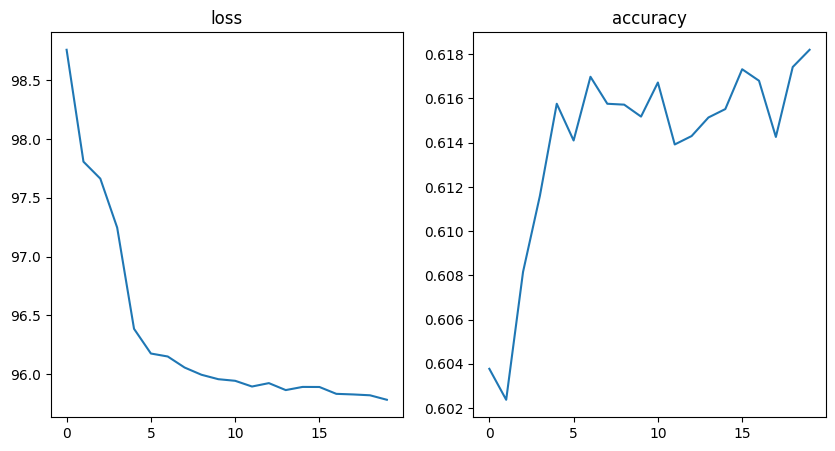

In [70]:
losses = []
acc = []
e = []
for i, d in enumerate(history):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax1)
ax1.set_title("loss")
sns.lineplot(acc, ax = ax2)
ax2.set_title("accuracy")
plt.show()


In [54]:
torch.save(model, 'model2.50epoch.h5')